# Validointi

Otetaan tarvittavat paketit käyttöön:

In [2]:
import numpy as np
import sdv
import scipy
import pandas as pd
import sdmetrics
from sdv.metadata import SingleTableMetadata
from sdmetrics.reports import utils
from sdv.single_table import TVAESynthesizer
from sdv.single_table import CTGANSynthesizer
#from sdv.evaluation.single_table import evaluate_quality

import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

import hyperimpute
from hyperimpute.plugins.imputers import Imputers, ImputerPlugin
imputers = Imputers()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from scipy import stats

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from keras import metrics

import tensorflow

from tensorflow.keras.models import Model

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold


2025-08-29 16:21:27.770342: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-29 16:21:27.790028: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-29 16:21:27.796068: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-29 16:21:27.810985: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-29 16:21:29.205909: W tensorflow/compiler/tf2

Ladataan testattavat tiedostot.

Käytetyt validointimenetelmät on pyritty valitsemaan niin että ne olisivat mahdollisimman riippumattomia vertailtavista dataseteistä, ts. esimerkiksi kahden aidon datasetin vertailu on myös mahdollista mikäli ne sisältävät samat muuttujat.

In [3]:
synth_tvae_data_list = []
synth_ctgan_data_list = [] 
synth_diffusion_data_list = [] 
synth_gcopula_data_list = [] 
synth_bayes_data_list = [] 
synth_nflow_data_list = []

training_data_list = []
test_data_list = []

for i in range(5):
    # Load the dataset
    tvae = pd.read_csv(f'../Generointi/data/tvae/synteettinen_tvae_data_{i}.csv', index_col=0)
    ctgan = pd.read_csv(f'../Generointi/data/ctgan/synteettinen_ctgan_data_{i}.csv', index_col=0)
    diffusion = pd.read_csv(f'../Generointi/data/diffusion/synteettinen_diffusion_data_{i}.csv', index_col=0)
    gcopula = pd.read_csv(f'../Generointi/data/gcopula/synteettinen_gcopula_data_{i}.csv', index_col=0)
    nflow = pd.read_csv(f'../Generointi/data/nflow/synteettinen_nflow_data_{i}.csv', index_col=0)
    bayes = pd.read_csv(f'../Generointi/data/bayes/synteettinen_bayes_data_{i}.csv', index_col=0)
    
    train_set = pd.read_csv(f'../Generointi/data/train/training_data_{i}.csv', index_col=0)
    test_set = pd.read_csv(f'../Generointi/data/test/testing_data_{i}.csv', index_col=0)

    # Append the data to the respective lists
    synth_tvae_data_list.append(tvae)
    synth_ctgan_data_list.append(ctgan)
    synth_diffusion_data_list.append(diffusion)
    synth_gcopula_data_list.append(gcopula)
    synth_bayes_data_list.append(bayes)
    synth_nflow_data_list.append(nflow)

    training_data_list.append(train_set)
    test_data_list.append(test_set)

In [4]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(training_data_list[0])

## SDMetrics Quality Report
SDMetricsin laaturaportti antaa työkaluja synteettisen datan tilastollisen laadun varmistamiseen.
Se koostuu kahdesta osiosta:
1. Column Shapes Score, joka on vastaavuus aidon ja synteettisen datan välillä kun tarkastellaan muuttujia yksitellen
2. Column Pair Trends, muuttujaparien korrelaatioiden vastaavuus aidon ja synteettisen datan välillä

Molemmat ilmoitetaan prosenttiarvona 0-100%, jossa 100% on täydellinen vastaavuus.
100% ei kuitenkaan ole käytännössä mahdollinen eikä edes tavoite, sillä se tarkoittaisi täydellistä kopiota
alkuperäisestä datasta. Yli 90% on melko hyvä, mutta alle sen ei luultavasti ole riittävä.

In [5]:
from sdmetrics.reports.single_table import QualityReport

def evaluate_quality(real_data, synthetic_data):
    """
    Evaluate the quality of synthetic data against real data.
    """
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(real_data)

    # Evaluate the quality of the synthetic data
    qr = QualityReport()
    qr.generate(real_data, synthetic_data, metadata=metadata.to_dict())
    
    return qr


### Referenssitaso testidatalla

Aito data jaettiin generointivaiheessa opetus- ja testiaineistoihin.
Testiaineistoa voidaan käyttää arvioimaan hyväksyttävä pistetaso, sillä jos opetus- ja testiaineisto oletetaan rippumattomiksi, voidaan
näiden välistä pisteytystä pitää viitteenä siitä mitä synteettisen ja aidon datan välisen pisteytyksen tulisi olla.


In [6]:

for i, test_fold in enumerate(test_data_list):

    qr = evaluate_quality(training_data_list[i], test_fold)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1522.59it/s]|
Column Shapes Score: 91.44%

(2/2) Evaluating Column Pair Trends: |          | 0/91 [00:00<?, ?it/s]|

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 166.09it/s]|
Column Pair Trends Score: 80.68%

Overall Score (Average): 86.06%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 2545.64it/s]|
Column Shapes Score: 92.1%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 134.44it/s]|
Column Pair Trends Score: 21.55%

Overall Score (Average): 56.83%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 2089.84it/s]|
Column Shapes Score: 92.71%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 162.41it/s]|
Column Pair Trends Score: 81.42%

Overall Score (Average): 87.07%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 2285.19it/s]|
Column Shapes Score: 93.01%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 192.38it/s]|
Column Pair Trends Score: 83.15%

Overall Score (Average): 88.08%

Generati

Huomataan että Column Shapes Score, eli yksittäisten muuttujien välinen vastaavuus on satunnaisjaolla 90-93%.
Muuttujaparien korrelaatioiden vastaavuus Column Pair Trends Score taas vaihtelee ja on yhdessä satunnaisjaossa jopa 21.55%!

Tarkastellaan tätä hieman tarkemmin:

In [7]:
bad_quality_report = evaluate_quality(training_data_list[1], test_data_list[1])

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 2183.88it/s]|
Column Shapes Score: 92.1%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 135.35it/s]|
Column Pair Trends Score: 21.55%

Overall Score (Average): 56.83%



In [8]:
bad_quality_report.get_details(property_name='Column Pair Trends')

,Column 1,Column 2,Metric,Score,Real Correlation,Synthetic Correlation
0,age,sex,ContingencySimilarity,0.000000,NaN,NaN
1,age,cp,ContingencySimilarity,0.000000,NaN,NaN
2,age,trestbps,CorrelationSimilarity,0.963193,0.268639,0.342254
3,age,chol,CorrelationSimilarity,0.956218,0.189492,0.277056
4,age,fbs,ContingencySimilarity,0.000000,NaN,NaN
...,...,...,...,...,...,...
86,slope,thal,ContingencySimilarity,0.000000,NaN,NaN
87,slope,num,ContingencySimilarity,0.000000,NaN,NaN
88,ca,thal,CorrelationSimilarity,0.971469,0.245879,0.302942
89,ca,num,ContingencySimilarity,0.000000,NaN,NaN


Jostain syystä suuri osa pisteytetään 0%, joka laskee huomattavasti keskiarvoa.
Verrokkina onnistunut pisteytys:

In [9]:
normal_quality_report = evaluate_quality(training_data_list[0], test_data_list[0])

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 2095.80it/s]|
Column Shapes Score: 91.44%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 186.33it/s]|
Column Pair Trends Score: 80.68%

Overall Score (Average): 86.06%



In [10]:
normal_quality_report.get_details(property_name='Column Pair Trends')

,Column 1,Column 2,Metric,Score,Real Correlation,Synthetic Correlation
0,age,sex,ContingencySimilarity,0.674976,NaN,NaN
1,age,cp,ContingencySimilarity,0.707763,NaN,NaN
2,age,trestbps,CorrelationSimilarity,0.965579,0.274823,0.343664
3,age,chol,CorrelationSimilarity,0.963929,0.222064,0.149923
4,age,fbs,ContingencySimilarity,0.748950,NaN,NaN
...,...,...,...,...,...,...
86,slope,thal,ContingencySimilarity,0.842366,NaN,NaN
87,slope,num,ContingencySimilarity,0.805311,NaN,NaN
88,ca,thal,CorrelationSimilarity,0.993411,0.252037,0.265215
89,ca,num,ContingencySimilarity,0.812627,NaN,NaN


Mikäli tämä testi hylätään epäonnistuneena, voidaan referenssitasoksi parittaisissa korrelaatioissa laskea n. 80%

Sama testi kaikille synteettisille dataseteille:

In [11]:

for i, syn_profile in enumerate(synth_bayes_data_list):

    qr = evaluate_quality(training_data_list[i], syn_profile)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1213.76it/s]|
Column Shapes Score: 67.04%

(2/2) Evaluating Column Pair Trends: |          | 0/91 [00:00<?, ?it/s]|

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 167.41it/s]|
Column Pair Trends Score: 59.21%

Overall Score (Average): 63.13%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1417.92it/s]|
Column Shapes Score: 67.34%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 186.41it/s]|
Column Pair Trends Score: 59.98%

Overall Score (Average): 63.66%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1348.12it/s]|
Column Shapes Score: 66.76%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 183.10it/s]|
Column Pair Trends Score: 58.41%

Overall Score (Average): 62.58%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1269.46it/s]|
Column Shapes Score: 68.35%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 183.00it/s]|
Column Pair Trends Score: 59.51%

Overall Score (Average): 63.93%

Generat

In [12]:
for i, syn_profile in enumerate(synth_tvae_data_list):

    qr = evaluate_quality(training_data_list[i], syn_profile)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1617.64it/s]|
Column Shapes Score: 94.63%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 182.21it/s]|
Column Pair Trends Score: 86.72%

Overall Score (Average): 90.67%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1847.30it/s]|
Column Shapes Score: 93.72%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 182.15it/s]|
Column Pair Trends Score: 88.9%

Overall Score (Average): 91.31%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 2033.67it/s]|
Column Shapes Score: 94.83%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 183.71it/s]|
Column Pair Trends Score: 83.62%

Overall Score (Average): 89.22%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1564.87it/s]|
Column Shapes Score: 93.53%

(2/2) Evaluating Column Pai

In [13]:
for i, syn_profile in enumerate(synth_ctgan_data_list):

    qr = evaluate_quality(training_data_list[i], syn_profile)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1657.17it/s]|
Column Shapes Score: 85.44%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 184.17it/s]|
Column Pair Trends Score: 80.25%

Overall Score (Average): 82.84%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1781.45it/s]|
Column Shapes Score: 88.47%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 183.83it/s]|
Column Pair Trends Score: 81.73%

Overall Score (Average): 85.1%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1648.06it/s]|
Column Shapes Score: 88.69%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 183.10it/s]|
Column Pair Trends Score: 83.87%

Overall Score (Average): 86.28%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1601.67it/s]|
Column Shapes Score: 87.61%

(2/2) Evaluating Column Pai

In [14]:
for i, syn_profile in enumerate(synth_gcopula_data_list):

    qr = evaluate_quality(training_data_list[i], syn_profile)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1365.33it/s]|
Column Shapes Score: 89.58%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 181.28it/s]|
Column Pair Trends Score: 82.08%

Overall Score (Average): 85.83%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1681.76it/s]|
Column Shapes Score: 89.85%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 173.76it/s]|
Column Pair Trends Score: 81.97%

Overall Score (Average): 85.91%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1857.06it/s]|
Column Shapes Score: 89.49%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 176.91it/s]|
Column Pair Trends Score: 81.55%

Overall Score (Average): 85.52%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1668.38it/s]|
Column Shapes Score: 89.41%

(2/2) Evaluating Column Pa

In [ ]:
for i, syn_profile in enumerate(synth_tvae_data_list):

    qr = evaluate_quality(training_data_list[i], syn_profile)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1174.33it/s]|
Column Shapes Score: 93.58%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 179.59it/s]|
Column Pair Trends Score: 88.93%

Overall Score (Average): 91.26%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1593.58it/s]|
Column Shapes Score: 91.09%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 184.05it/s]|
Column Pair Trends Score: 86.46%

Overall Score (Average): 88.77%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1999.60it/s]|
Column Shapes Score: 92.12%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 183.74it/s]|
Column Pair Trends Score: 88.15%

Overall Score (Average): 90.14%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1665.82it/s]|
Column Shapes Score: 90.63%

(2/2) Evaluating Column Pa

In [16]:
for i, syn_profile in enumerate(synth_diffusion_data_list):

    qr = evaluate_quality(training_data_list[i], syn_profile)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1028.09it/s]|
Column Shapes Score: 58.87%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 177.41it/s]|
Column Pair Trends Score: 51.14%

Overall Score (Average): 55.01%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1261.85it/s]|
Column Shapes Score: 70.05%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 179.48it/s]|
Column Pair Trends Score: 55.54%

Overall Score (Average): 62.79%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1324.95it/s]|
Column Shapes Score: 72.44%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:00<00:00, 167.75it/s]|
Column Pair Trends Score: 50.3%

Overall Score (Average): 61.37%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 1288.60it/s]|
Column Shapes Score: 61.73%

(2/2) Evaluating Column Pai

Menetelmien välillä on huomattavia eroja. Tämä ei kuitenkaan tarkoita että osa malleista olisi täysin käyttökelvottomia: Vaikka diffuusiomalli epäonnistuikin tämän datasetin syntetisoinnissa, ne ovat useiden kuvageneraattoreiden pohjamalli. Tähän voi vaikuttaa datan määrä ja luonne, eli esimerkiksi kuinka suuri osa muuttujista on diskreettejä.

Osa synteettisistä aineistoista tuotti suuremmat pisteet kuin referenssi testiaineistolla. Tämä voi olla merkki ylisovittumisesta, mutta ei ole lähtökohtaisesti yhtä huono kuin alhaiset pisteet.

SDMetrics tarjoaa myös helppoja visualisointikeinoja:

In [17]:
from sdmetrics.visualization import get_column_plot

fig = get_column_plot(
    real_data=training_data_list[0],
    synthetic_data=test_data_list[0],
    column_name='age',
    plot_type='distplot'
)

fig.show()

In [18]:
from sdmetrics.visualization import get_column_pair_plot

fig = get_column_pair_plot(
    real_data=training_data_list[0],
    synthetic_data=test_data_list[0],
    column_names=['age', 'thalach'],
    plot_type='scatter'
    
)

fig.show()

## Utility

Synteettisen datan laatua voidaan estimoida myös sovittamalla erilaisia malleja aidolla ja synteettisellä datalla, ja vertailemalla niiden suorituskykyä.

GradBoost', 'RandForest', 'SVM', 'NearNeigh', 'DecTree', 'MLP', 'Regress'


In [34]:
import utils



In [24]:
utils.calc_corr_score(
    training_data_list[0],
    test_data_list[0])


0.9503695178965224

In [25]:
utils.ks_score(
    training_data_list[0],
    test_data_list[0])

0.9149553873845975

(0.9149553873845975, 0.9503695178965224)

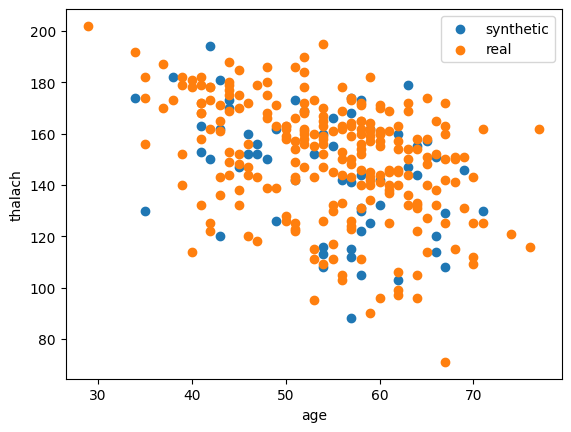

In [ ]:

utils.visualize_and_test(training_data_list[0],test_data_list[0], 'age', 'thalach')


Sovitetaan mallit kolmelle eri synteettiselle datalle

In [76]:
from val_utils  import utility_test
num_metrics_list, categorical_metrics_list = [], []

for i in range(5):
    num_metrics, categorical_metrics = utility_test(synth_nflow_data_list[i],training_data_list[i], test_data_list[i])  
    num_metrics_list.append(num_metrics)
    categorical_metrics_list.append(categorical_metrics)

numerical_multiarray_nflow = pd.concat(num_metrics_list, keys=range(0,5))
categorical_multiarray_nflow = pd.concat(categorical_metrics_list, keys=range(0,5))

In [77]:
num_metrics_list, categorical_metrics_list = [], []

for i in range(5):
    num_metrics, categorical_metrics = utility_test(synth_tvae_data_list[i],training_data_list[i], test_data_list[i])  
    num_metrics_list.append(num_metrics)
    categorical_metrics_list.append(categorical_metrics)

numerical_multiarray_tvae = pd.concat(num_metrics_list, keys=range(0,5))
categorical_multiarray_tvae = pd.concat(categorical_metrics_list, keys=range(0,5))

In [78]:
num_metrics_list, categorical_metrics_list = [], []

for i in range(5):
    num_metrics, categorical_metrics = utility_test(synth_diffusion_data_list[i],training_data_list[i], test_data_list[i])  
    num_metrics_list.append(num_metrics)
    categorical_metrics_list.append(categorical_metrics)

numerical_multiarray_diffusion = pd.concat(num_metrics_list, keys=range(0,5))
categorical_multiarray_diffusion = pd.concat(categorical_metrics_list, keys=range(0,5))

Piirretään näistä Gradient Boosting -mallista kuviot:

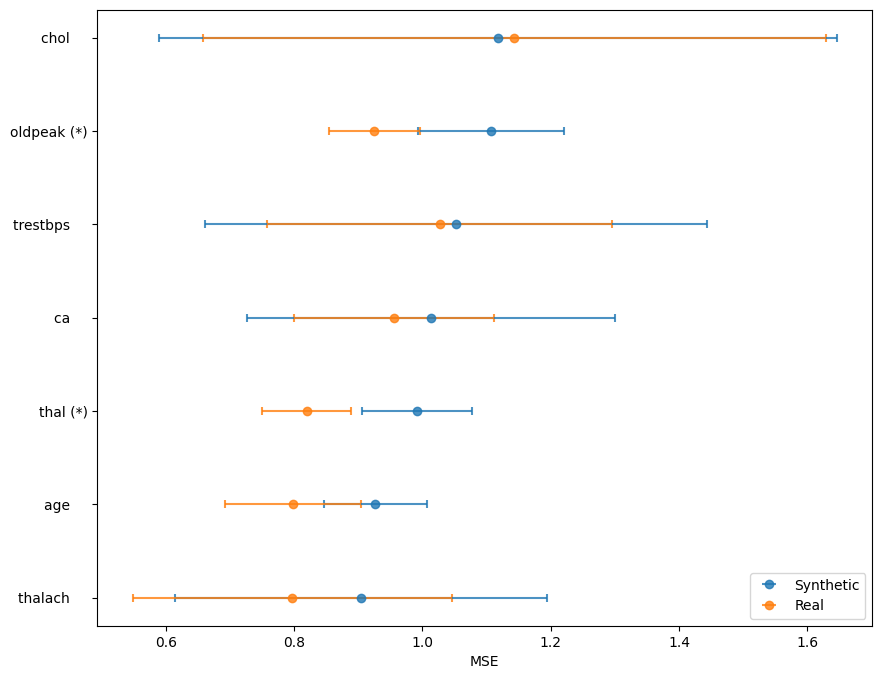

In [79]:
columns = numerical_multiarray_nflow.loc[:,'MSE_tstr', 'GradBoost'].columns.to_numpy()
gb_MSE_tstr = pd.DataFrame(np.mean(numerical_multiarray_nflow.loc[:,'MSE_tstr', 'GradBoost'],axis=0))
gb_MSE_trtr = pd.DataFrame(np.mean(numerical_multiarray_nflow.loc[:,'MSE_trtr', 'GradBoost'],axis=0))
gb_MSE_tstr_std = pd.DataFrame(np.std(numerical_multiarray_nflow.loc[:,'MSE_tstr', 'GradBoost'],axis=0))
gb_MSE_trtr_std = pd.DataFrame(np.std(numerical_multiarray_nflow.loc[:,'MSE_trtr', 'GradBoost'],axis=0))

reg_MSE_tstr = pd.DataFrame(np.mean(numerical_multiarray_nflow.loc[:,'MSE_tstr', 'Regress'],axis=0))
reg_MSE_trtr = pd.DataFrame(np.mean(numerical_multiarray_nflow.loc[:,'MSE_trtr', 'Regress'],axis=0))
reg_MSE_tstr_std = pd.DataFrame(np.std(numerical_multiarray_nflow.loc[:,'MSE_tstr', 'Regress'],axis=0))
reg_MSE_trtr_std = pd.DataFrame(np.std(numerical_multiarray_nflow.loc[:,'MSE_trtr', 'Regress'],axis=0))

cmap = plt.get_cmap("tab10")
fig = plt.figure(figsize=(10,8))

columns_significance = [x + ' (*)' if stats.ttest_ind(numerical_multiarray_nflow.loc[:,'MSE_tstr', 'GradBoost'][x],numerical_multiarray_nflow.loc[:,'MSE_trtr', 'GradBoost'][x], equal_var=False).pvalue<(0.05) else x + '    '   for x in columns]

# plt.scatter(pd.DataFrame(np.mean(numerical_multiarray.loc[:,'RMSE_tstr', 'GradBoost'],axis=0)),measure_2_columns,)
sorted_mean_tstr, sorted_mean_trtr, sorted_std_tstr, sorted_std_trtr,columns_significance = (list(x) for x in zip(*sorted(zip(np.squeeze(gb_MSE_tstr.to_numpy()), np.squeeze(gb_MSE_trtr.to_numpy()), np.squeeze(gb_MSE_tstr_std.to_numpy()), np.squeeze(gb_MSE_trtr_std.to_numpy()),columns_significance))))
plt.errorbar(sorted_mean_tstr,y=columns_significance,  xerr=sorted_std_tstr, fmt='o',alpha=0.8, label ='Synthetic')
plt.errorbar(sorted_mean_trtr,y=columns_significance,  xerr=sorted_std_trtr, fmt='o',alpha=0.8, label ='Real')


plt.scatter(pd.DataFrame(np.array(sorted_mean_tstr) +np.array(sorted_std_tstr)),
            columns_significance,marker='|',color=cmap(0),alpha=0.8)
plt.scatter(pd.DataFrame(np.array(sorted_mean_tstr) -np.array(sorted_std_tstr)),
            columns_significance,marker='|',color=cmap(0),alpha=0.8)

plt.scatter(pd.DataFrame(np.array(sorted_mean_trtr) +np.array(sorted_std_trtr)),
            columns_significance,marker='|',color=cmap(1),alpha=0.8)
plt.scatter(pd.DataFrame(np.array(sorted_mean_trtr) -np.array(sorted_std_trtr)),
            columns_significance,marker='|',color=cmap(1),alpha=0.8)

plt.legend()
plt.xlabel('MSE')

plt.show()

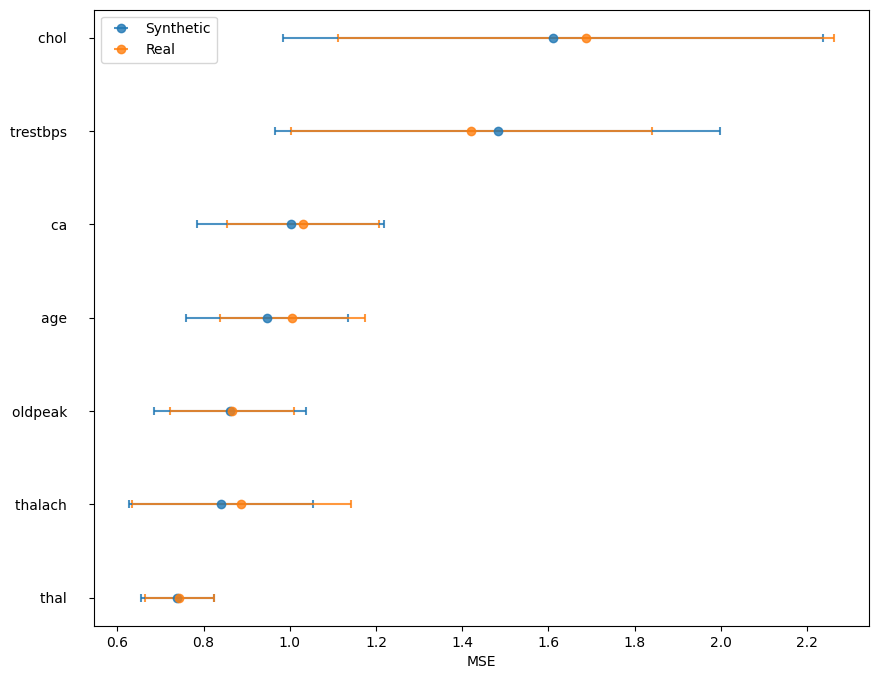

In [80]:
columns = numerical_multiarray_tvae.loc[:,'MSE_tstr', 'GradBoost'].columns.to_numpy()
gb_MSE_tstr = pd.DataFrame(np.mean(numerical_multiarray_tvae.loc[:,'MSE_tstr', 'GradBoost'],axis=0))
gb_MSE_trtr = pd.DataFrame(np.mean(numerical_multiarray_tvae.loc[:,'MSE_trtr', 'GradBoost'],axis=0))
gb_MSE_tstr_std = pd.DataFrame(np.std(numerical_multiarray_tvae.loc[:,'MSE_tstr', 'GradBoost'],axis=0))
gb_MSE_trtr_std = pd.DataFrame(np.std(numerical_multiarray_tvae.loc[:,'MSE_trtr', 'GradBoost'],axis=0))

reg_MSE_tstr = pd.DataFrame(np.mean(numerical_multiarray_tvae.loc[:,'MSE_tstr', 'Regress'],axis=0))
reg_MSE_trtr = pd.DataFrame(np.mean(numerical_multiarray_tvae.loc[:,'MSE_trtr', 'Regress'],axis=0))
reg_MSE_tstr_std = pd.DataFrame(np.std(numerical_multiarray_tvae.loc[:,'MSE_tstr', 'Regress'],axis=0))
reg_MSE_trtr_std = pd.DataFrame(np.std(numerical_multiarray_tvae.loc[:,'MSE_trtr', 'Regress'],axis=0))

cmap = plt.get_cmap("tab10")
fig = plt.figure(figsize=(10,8))

columns_significance = [x + ' (*)' if stats.ttest_ind(numerical_multiarray_tvae.loc[:,'MSE_tstr', 'GradBoost'][x],numerical_multiarray_tvae.loc[:,'MSE_trtr', 'GradBoost'][x], equal_var=False).pvalue<(0.05) else x + '    '   for x in columns]

# plt.scatter(pd.DataFrame(np.mean(numerical_multiarray.loc[:,'RMSE_tstr', 'GradBoost'],axis=0)),measure_2_columns,)
sorted_mean_tstr, sorted_mean_trtr, sorted_std_tstr, sorted_std_trtr,columns_significance = (list(x) for x in zip(*sorted(zip(np.squeeze(gb_MSE_tstr.to_numpy()), np.squeeze(gb_MSE_trtr.to_numpy()), np.squeeze(gb_MSE_tstr_std.to_numpy()), np.squeeze(gb_MSE_trtr_std.to_numpy()),columns_significance))))
plt.errorbar(sorted_mean_tstr,y=columns_significance,  xerr=sorted_std_tstr, fmt='o',alpha=0.8, label ='Synthetic')
plt.errorbar(sorted_mean_trtr,y=columns_significance,  xerr=sorted_std_trtr, fmt='o',alpha=0.8, label ='Real')


plt.scatter(pd.DataFrame(np.array(sorted_mean_tstr) +np.array(sorted_std_tstr)),
            columns_significance,marker='|',color=cmap(0),alpha=0.8)
plt.scatter(pd.DataFrame(np.array(sorted_mean_tstr) -np.array(sorted_std_tstr)),
            columns_significance,marker='|',color=cmap(0),alpha=0.8)

plt.scatter(pd.DataFrame(np.array(sorted_mean_trtr) +np.array(sorted_std_trtr)),
            columns_significance,marker='|',color=cmap(1),alpha=0.8)
plt.scatter(pd.DataFrame(np.array(sorted_mean_trtr) -np.array(sorted_std_trtr)),
            columns_significance,marker='|',color=cmap(1),alpha=0.8)

plt.legend()
plt.xlabel('MSE')

plt.show()

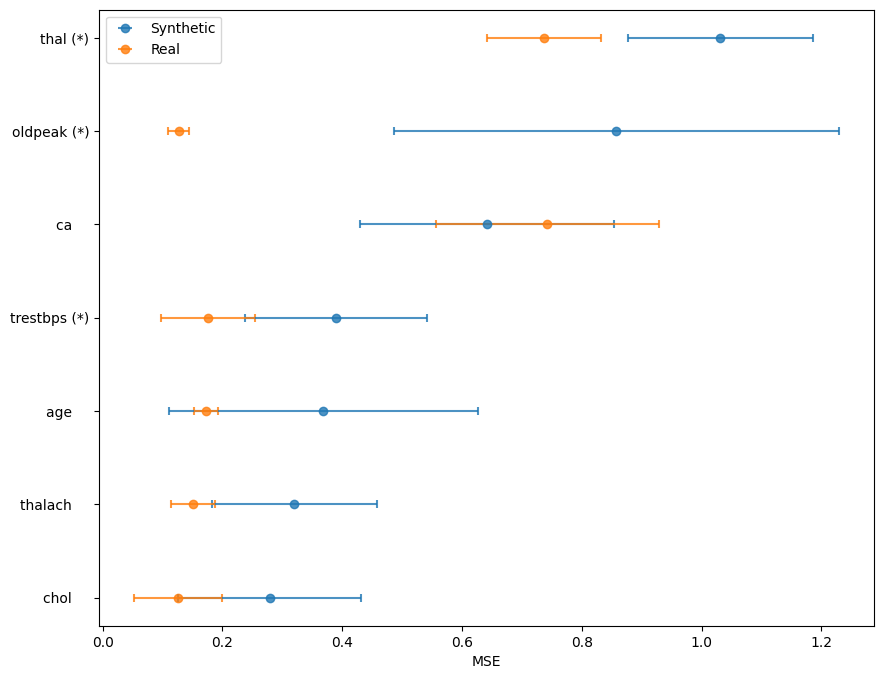

In [81]:
columns = numerical_multiarray_diffusion.loc[:,'MSE_tstr', 'GradBoost'].columns.to_numpy()
gb_MSE_tstr = pd.DataFrame(np.mean(numerical_multiarray_diffusion.loc[:,'MSE_tstr', 'GradBoost'],axis=0))
gb_MSE_trtr = pd.DataFrame(np.mean(numerical_multiarray_diffusion.loc[:,'MSE_trtr', 'GradBoost'],axis=0))
gb_MSE_tstr_std = pd.DataFrame(np.std(numerical_multiarray_diffusion.loc[:,'MSE_tstr', 'GradBoost'],axis=0))
gb_MSE_trtr_std = pd.DataFrame(np.std(numerical_multiarray_diffusion.loc[:,'MSE_trtr', 'GradBoost'],axis=0))

reg_MSE_tstr = pd.DataFrame(np.mean(numerical_multiarray_diffusion.loc[:,'MSE_tstr', 'Regress'],axis=0))
reg_MSE_trtr = pd.DataFrame(np.mean(numerical_multiarray_diffusion.loc[:,'MSE_trtr', 'Regress'],axis=0))
reg_MSE_tstr_std = pd.DataFrame(np.std(numerical_multiarray_diffusion.loc[:,'MSE_tstr', 'Regress'],axis=0))
reg_MSE_trtr_std = pd.DataFrame(np.std(numerical_multiarray_diffusion.loc[:,'MSE_trtr', 'Regress'],axis=0))

cmap = plt.get_cmap("tab10")
fig = plt.figure(figsize=(10,8))

columns_significance = [x + ' (*)' if stats.ttest_ind(numerical_multiarray_diffusion.loc[:,'MSE_tstr', 'GradBoost'][x],numerical_multiarray_diffusion.loc[:,'MSE_trtr', 'GradBoost'][x], equal_var=False).pvalue<(0.05) else x + '    '   for x in columns]

# plt.scatter(pd.DataFrame(np.mean(numerical_multiarray.loc[:,'RMSE_tstr', 'GradBoost'],axis=0)),measure_2_columns,)
sorted_mean_tstr, sorted_mean_trtr, sorted_std_tstr, sorted_std_trtr,columns_significance = (list(x) for x in zip(*sorted(zip(np.squeeze(gb_MSE_tstr.to_numpy()), np.squeeze(gb_MSE_trtr.to_numpy()), np.squeeze(gb_MSE_tstr_std.to_numpy()), np.squeeze(gb_MSE_trtr_std.to_numpy()),columns_significance))))
plt.errorbar(sorted_mean_tstr,y=columns_significance,  xerr=sorted_std_tstr, fmt='o',alpha=0.8, label ='Synthetic')
plt.errorbar(sorted_mean_trtr,y=columns_significance,  xerr=sorted_std_trtr, fmt='o',alpha=0.8, label ='Real')


plt.scatter(pd.DataFrame(np.array(sorted_mean_tstr) +np.array(sorted_std_tstr)),
            columns_significance,marker='|',color=cmap(0),alpha=0.8)
plt.scatter(pd.DataFrame(np.array(sorted_mean_tstr) -np.array(sorted_std_tstr)),
            columns_significance,marker='|',color=cmap(0),alpha=0.8)

plt.scatter(pd.DataFrame(np.array(sorted_mean_trtr) +np.array(sorted_std_trtr)),
            columns_significance,marker='|',color=cmap(1),alpha=0.8)
plt.scatter(pd.DataFrame(np.array(sorted_mean_trtr) -np.array(sorted_std_trtr)),
            columns_significance,marker='|',color=cmap(1),alpha=0.8)

plt.legend()
plt.xlabel('MSE')

plt.show()

In [73]:
columns

array(['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'thal'],
      dtype=object)

VAE vaikuttaa kokonaisuudessaan parhaalta mallilta tälle datalle

## Privacy

In [ ]:
test_mean_2close_ratio_list = []
synth_mean_2close_ratio_list = []
test_std_2close_ratio_list = []
synth_std_2close_ratio_list = []

test_max_2close_ratio_list = []
synth_max_2close_ratio_list = []
test_min_2close_ratio_list = []
synth_min_2close_ratio_list = []

ratios_test = []
ratios_synth = []

for i in range(0,10):
    scaler_minmax = MinMaxScaler()
    real_df_train_scaled = scaler_minmax.fit_transform(real_df_train_list[i].drop('ID', axis=1))
    real_df_test_scaled = scaler_minmax.transform(real_df_test_list[i].drop('ID', axis=1))
    synth_scaled = scaler_minmax.transform(synthetic_df_cond_list[i])

    two_closest_ratio_list_real = []
    for test_dude in real_df_test_scaled:
        test_dude_distances = []
        for real_dude in real_df_train_scaled:
            test_dude_distances.append(np.linalg.norm(real_dude-test_dude))
        test_dude_distances_sorted = np.sort(np.array(test_dude_distances))
        two_closest_ratio_list_real.append(test_dude_distances_sorted[0]/test_dude_distances_sorted[1])

    test_mean_2close_ratio_list.append(np.mean(two_closest_ratio_list_real))
    test_std_2close_ratio_list.append(np.std(two_closest_ratio_list_real))
    test_max_2close_ratio_list.append(np.max(two_closest_ratio_list_real))
    test_min_2close_ratio_list.append(np.min(two_closest_ratio_list_real))

    ratios_test.append(two_closest_ratio_list_real)

    two_closest_ratio_list_synth = []
    for synth_dude in synth_scaled:
        synth_dude_distances = []
        for real_dude in real_df_train_scaled:
            synth_dude_distances.append(np.linalg.norm(real_dude-synth_dude))
        synth_dude_distances_sorted = np.sort(np.array(synth_dude_distances))
        two_closest_ratio_list_synth.append(synth_dude_distances_sorted[0]/synth_dude_distances_sorted[1])

    synth_mean_2close_ratio_list.append(np.mean(two_closest_ratio_list_synth))
    synth_std_2close_ratio_list.append(np.std(two_closest_ratio_list_synth))
    synth_max_2close_ratio_list.append(np.max(two_closest_ratio_list_synth))
    synth_min_2close_ratio_list.append(np.min(two_closest_ratio_list_synth))

    ratios_synth.append(two_closest_ratio_list_synth)